<a href="https://colab.research.google.com/github/IamGuts/data_science/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D1%84%D0%B0%D0%B9%D0%BB%D0%B0__%D0%93%D1%80%D0%B8%D0%B1%D1%8B_%D1%81%D1%8A%D0%B5%D0%B4%D0%BE%D0%B1%D0%BD%D1%8B%D0%B5_%D0%B8_%D0%BD%D0%B5%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Задача - на основании имеющихся данных о физических параметрах грибов, построить модель классификации о том, можно или нельзя есть данный гриб.

Target - колонка class

Все остальные - признаки

Постараться использовать все изученные техники:

- если есть, заполнить  пропуски
- посмотреть корреляции и выбрать только нужные признаки
- удалить выбросы (значения выпадающие за 90% квантиль)
- закодировать категориальные признаки
- оценить баланс классов

Построить модель и оценить результат

Оформить результат в виде блокнота, следующего наименования **ДЗ_Фамилия_Имя.ipynb** и положить в исходную папку

In [ ]:

import pandas as pd
import numpy as np

In [ ]:
from google.colab import files
files.upload()

##Обработка данных

In [ ]:
df = pd.read_csv('mushroom_cleaned.csv.zip')

Посмотрим на часть даных

In [ ]:
df.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


просмотр размера датфрейма

In [ ]:
df.shape

(54035, 9)

проверка на пропущеные значения

In [ ]:
df.isna().sum()

,0
cap-diameter,0
cap-shape,0
gill-attachment,0
gill-color,0
stem-height,0
stem-width,0
stem-color,0
season,0
class,0


просмотр информации колонок

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54035 entries, 0 to 54034
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cap-diameter     54035 non-null  int64  
 1   cap-shape        54035 non-null  int64  
 2   gill-attachment  54035 non-null  int64  
 3   gill-color       54035 non-null  int64  
 4   stem-height      54035 non-null  float64
 5   stem-width       54035 non-null  int64  
 6   stem-color       54035 non-null  int64  
 7   season           54035 non-null  float64
 8   class            54035 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 3.7 MB


Как заметно из описание в данных отсутствуют категориальные переменные , по этому копировка не имеет место

In [ ]:
df.describe()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
count,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000
mean,567.257204,4.000315,2.142056,7.329509,0.759110,1051.081299,8.418062,0.952163,0.549181
std,359.883763,2.160505,2.228821,3.200266,0.650969,782.056076,3.262078,0.305594,0.497580
min,0.000000,0.000000,0.000000,0.000000,0.000426,0.000000,0.000000,0.027372,0.000000
25%,289.000000,2.000000,0.000000,5.000000,0.270997,421.000000,6.000000,0.888450,0.000000
50%,525.000000,5.000000,1.000000,8.000000,0.593295,923.000000,11.000000,0.943195,1.000000
75%,781.000000,6.000000,4.000000,10.000000,1.054858,1523.000000,11.000000,0.943195,1.000000
max,1891.000000,6.000000,6.000000,11.000000,3.835320,3569.000000,12.000000,1.804273,1.000000


Разделим данные на признаки и целевые

Постром бокс сусами да бы увидеть верна ли гипотеза на счёт выбросов и подтвердить свои догадки

## Работа с распределением

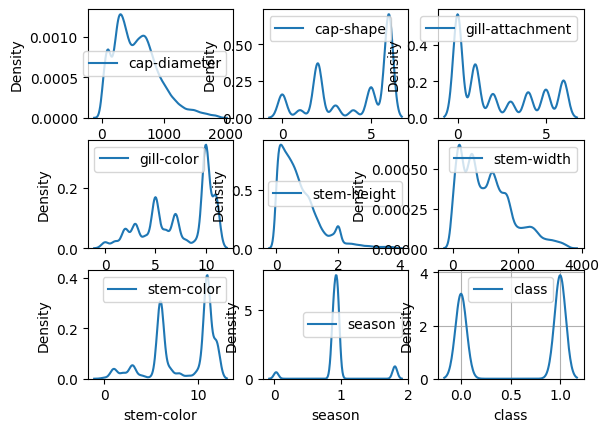

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
a,b,c = 3,3,1

for subdata in df:


    plt.subplot(3,3,c)

    sns.kdeplot(df[subdata],label=subdata)
    c += 1
    plt.legend()
plt.grid()
plt.show()

Как мы можем фиксировать зрительным нервом, данные имеют ненормальное распределение , будем это исправлять.
 - для графиков уходящих в право мы будем использовать метод логарифмической трансформации Y = log(X)

 - для графиков уходящих в лево мы будем использовать метод обратной трансформации Y = 1 / X

Данные имеющие сдвиг в правую часть находятся в колонках cap-shape, gill-color, stem-color.
В свою очередь данные имеющие сдвиг в левую часть находятся в колонка cap-diameter, gill-attachment, stem-height и stem-width.
Для остальных мы попробуем метод бокса-кокса или его продвинутые вариации

In [ ]:
right_feature = df[['cap-shape', 'gill-color', 'stem-color',]]
left_feature = df[[ 'gill-attachment', 'stem-height', 'stem-width']]

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


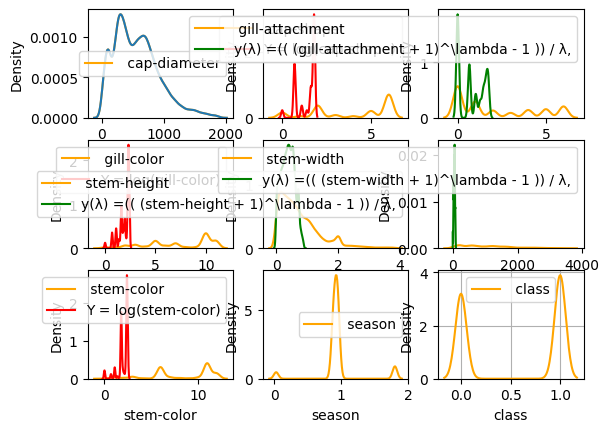

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
# Инициализация переменной для номера подграфика
c = 1
 # Установка размера фигуры
X = df.copy()
# Проходим по каждому элементу в списке featurs
for sub_data in df:

    plt.subplot(3,3,c) # Создаем подграфик в сетке 8x1
    c += 1  # Увеличиваем номер подграфика на 1


    # Исходный график распределения данных
    sns.kdeplot(
        X[sub_data],
        color = 'orange',
        label = f' {sub_data}'  # Подпись для графика с исходными данными
    )

 # Логарифмируем часть данных со сдвигом вправо, если это "правый" признак
    if sub_data in right_feature.columns:
        X[sub_data] = np.log(X[sub_data])   # Применение логарифмической трансформации
        sns.kdeplot(
            X[sub_data],
            color = 'red',
            label = f'Y = log({sub_data})'   # Подпись для логарифмированного графика
        )

# Применяем трансформацию Yeo-Johnson для "левых" признаков
    elif sub_data in left_feature.columns:
        X[sub_data], lambda_optimal = stats.yeojohnson(X[sub_data])
        sns.kdeplot(
            X[sub_data],
            color = 'green',
            label = f'y(λ) =(( ({sub_data} + 1)^\lambda - 1 )) / λ,'  # Подпись для графика Yeo-Johnson
        )
    elif sub_data == "cap-diameter":
        sns.kdeplot(
            (X[sub_data])
            )

    plt.legend() # Отображаем легенду на графике


plt.grid()  # Добавляем сетку на график
plt.show()  # Отображаем все графики

проверяем корреляцию данных ,  в прошлый раз ( но вы не видили) она была чудовищной)

## Раота с выбросами


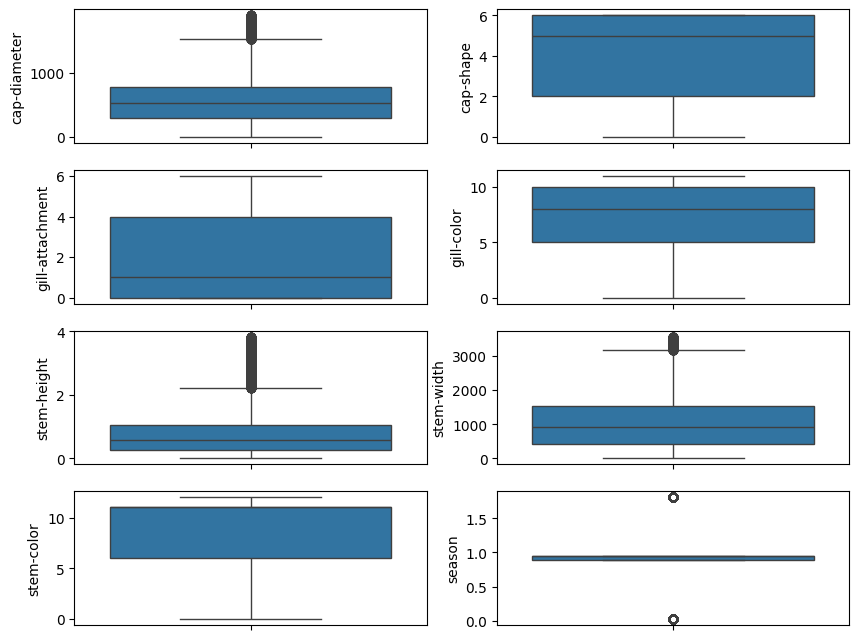

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
a,b,c = 4,2,1
for feature in X.drop(['class'], axis = 1):
    plt.subplot(a,b,c)
    sns.boxplot(df[feature])
    c += 1

Чтож, мы оказались прав ,данные признаки действительно имеют выбросы. Попробуем избавиться он них

In [ ]:


def remove_outliers_iqr(df, column):
    """
    Удаляет выбросы из указанного столбца DataFrame на основе межквартильного диапазона (IQR).

    :param df: DataFrame, из которого нужно удалить выбросы
    :param column: Название столбца, в котором нужно удалить выбросы
    :return: DataFrame без выбросов в указанном столбце
    """
    # Вычисляем первый (Q1) и третий (Q3) квартиль
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Вычисляем IQR
    IQR = Q3 - Q1

    # Определяем границы для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Убираем выбросы
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return filtered_df

# Создаем копию DataFrame для работы с ней
data = X.copy()

# Применяем функцию к каждому числовому столбцу DataFrame
for column in df.select_dtypes(include=['number']).columns:
    data = remove_outliers_iqr(data, column)

In [ ]:
data.shape

(38483, 9)

Посмотрим на наличие выброса у отфильтрованного датаырейма

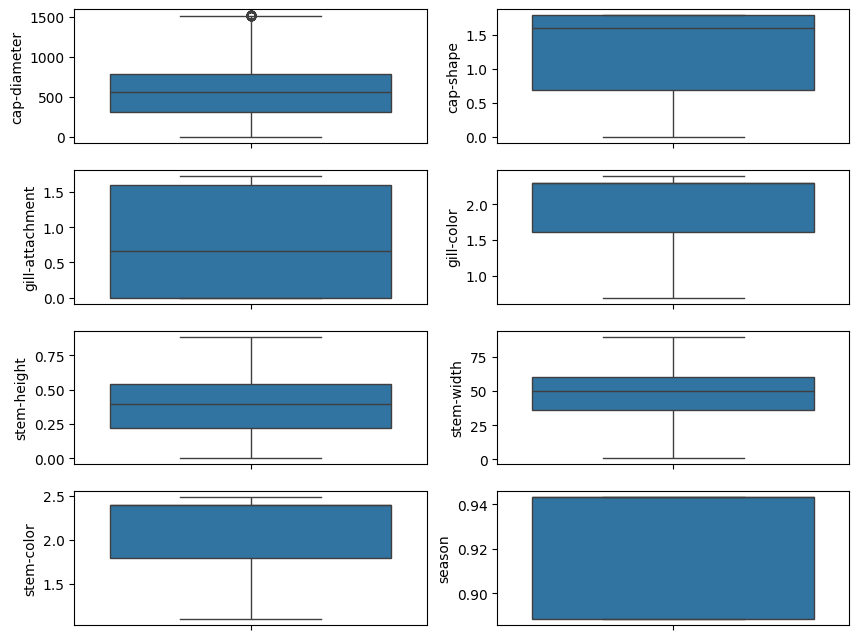

In [ ]:
plt.figure(figsize=(10,8))
a,b,c = 4,2,1
for feature in data.drop(['class'], axis = 1):
    plt.subplot(a,b,c)
    sns.boxplot(data[feature])
    c += 1

Как можно заметить пришлось удалить околоко 10тыс строк, но мы сохранили колонку , будем надеяться что не зря)

## Работа с корреляцией

<Axes: >

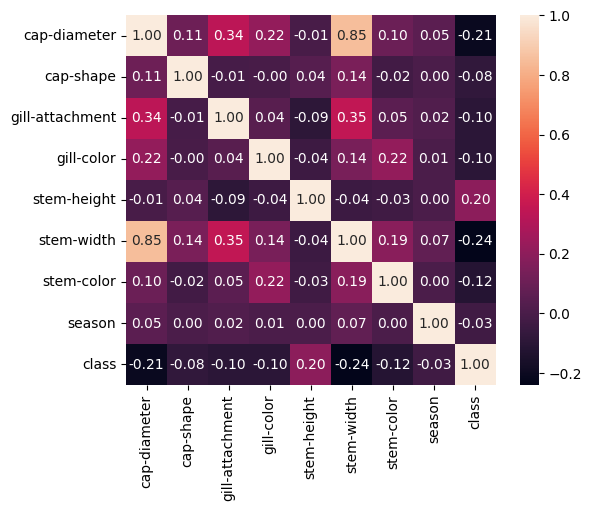

In [ ]:
sns.heatmap(X.corr(), annot = True,
            fmt='.2f',
            square=True)

In [ ]:
#удалим нафик cap-diameter чтобы небыло переобучения мобели в его сторону
X = X.drop(['cap-diameter'], axis = 1)

как видим что на корреляцию cap-diameter это никак не повлияло, ну чтож попробуем обучить модель

## Обучение модели

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
   # Замена бесконечных значений на NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

   # Теперь можно обработать NaN
X.fillna(X.mean(), inplace=True)  # Замена NaN на среднее значение

In [ ]:
y = X['class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(['class',], axis = 1),
    y,
    test_size=0.15,
    random_state=42
)

In [ ]:
pipe = Pipeline (
    [
        ('Scaler', StandardScaler()),
        ("Classifier", LogisticRegression())

    ]
)
pipe.fit(X_train,y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('Classifier', LogisticRegression())])

In [ ]:
pipe.predict(X_test)

array([0, 1, 0, ..., 0, 1, 1])

In [ ]:
pipe.predict_proba(X_test)

array([[0.81102789, 0.18897211],
       [0.38346279, 0.61653721],
       [0.61451726, 0.38548274],
       ...,
       [0.71696266, 0.28303734],
       [0.34593595, 0.65406405],
       [0.2285534 , 0.7714466 ]])

In [ ]:
mean_absolute_error(pipe.predict(X_test),y_test)

0.38107574636072045

In [ ]:
pipe.score(X_test,y_test)

0.6189242536392795

Провери на данных не обработаных

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
sns.relplot(data=df, x='bill_length_mm', y='flipper_length_mm', kind='scatter', hue='species', col='sex')

In [ ]:
knn = Pipeline([
 ('scaler', StandardScaler()),
('Classifier', KNeighborsClassifier(n_neighbors=4))
])
knn.fit(X_train, y_train)
print(f' точность кнн {accuracy_score(y_test, knn.predict(X_test)) * 100 :.2f}%')

 точность кнн 98.14%


In [ ]:
X_test['predict'] = knn.predict(X_test)

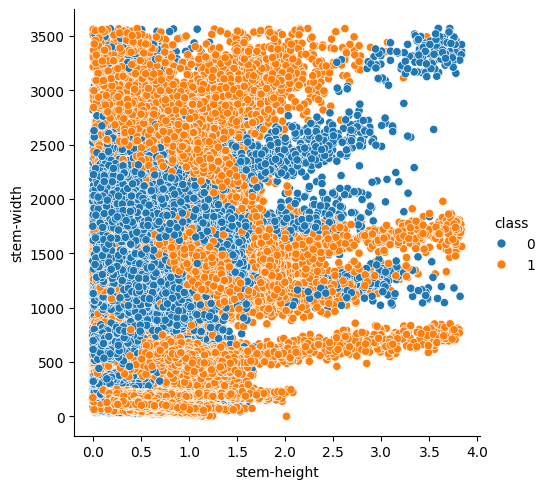

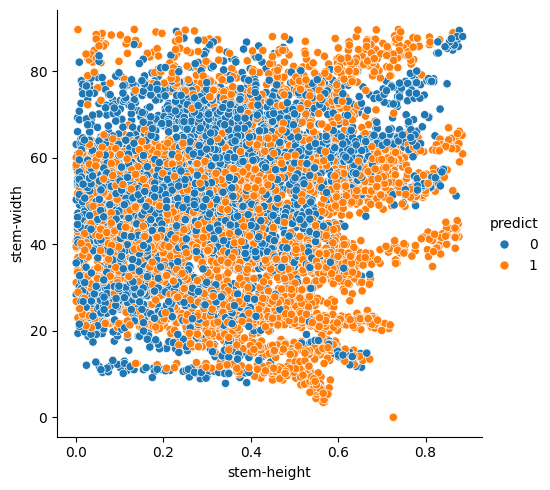

In [ ]:

sns.relplot(data=df,x='stem-height', y='stem-width', kind='scatter', hue='class')
sns.relplot(data=X_test, x='stem-height', y='stem-width', kind='scatter', hue='predict')